In [1]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns 
from scipy.stats import skew, kurtosis

from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV


from sklearn.linear_model import LinearRegression, Ridge, Lasso 
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR

In [2]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

train

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0000,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0000,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0000,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0000,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0000,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...
10881,2012-12-19 19:00:00,4,0,1,1,15.58,19.695,50,26.0027,7,329,336
10882,2012-12-19 20:00:00,4,0,1,1,14.76,17.425,57,15.0013,10,231,241
10883,2012-12-19 21:00:00,4,0,1,1,13.94,15.910,61,15.0013,4,164,168
10884,2012-12-19 22:00:00,4,0,1,1,13.94,17.425,61,6.0032,12,117,129


In [3]:
sample = pd.read_csv('sampleSubmission.csv')
sample

,datetime,count
0,2011-01-20 00:00:00,0
1,2011-01-20 01:00:00,0
2,2011-01-20 02:00:00,0
3,2011-01-20 03:00:00,0
4,2011-01-20 04:00:00,0
...,...,...
6488,2012-12-31 19:00:00,0
6489,2012-12-31 20:00:00,0
6490,2012-12-31 21:00:00,0
6491,2012-12-31 22:00:00,0


# preprocessing

In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   datetime    10886 non-null  object 
 1   season      10886 non-null  int64  
 2   holiday     10886 non-null  int64  
 3   workingday  10886 non-null  int64  
 4   weather     10886 non-null  int64  
 5   temp        10886 non-null  float64
 6   atemp       10886 non-null  float64
 7   humidity    10886 non-null  int64  
 8   windspeed   10886 non-null  float64
 9   casual      10886 non-null  int64  
 10  registered  10886 non-null  int64  
 11  count       10886 non-null  int64  
dtypes: float64(3), int64(8), object(1)
memory usage: 1020.7+ KB


In [5]:
train.isna().sum()

datetime      0
season        0
holiday       0
workingday    0
weather       0
temp          0
atemp         0
humidity      0
windspeed     0
casual        0
registered    0
count         0
dtype: int64

### change data types appropriately

### season, holiday, workingday, weather - change dtype to category 
### datetime - parse into year, month, date, hour

In [6]:
train = train.astype({'season':'category','holiday':'category', 'workingday':'category', 'holiday':'category'})
test = test.astype({'season':'category','holiday':'category', 'workingday':'category', 'holiday':'category'})

In [7]:
train['datetime'][0].split('-')[2].split(' ')[1][0:2]

'00'

In [8]:
train['year'] = train['datetime'].apply(lambda x : x.split('-')[0])
train['month'] = train['datetime'].apply(lambda x : x.split('-')[1])
train['date'] = train['datetime'].apply(lambda x : x.split('-')[2].split(' ')[0])
train['hour'] = train['datetime'].apply(lambda x : x.split('-')[2].split(' ')[1][0:2])

test['year'] = test['datetime'].apply(lambda x : x.split('-')[0])
test['month'] = test['datetime'].apply(lambda x : x.split('-')[1])
test['date'] = test['datetime'].apply(lambda x : x.split('-')[2].split(' ')[0])
test['hour'] = test['datetime'].apply(lambda x : x.split('-')[2].split(' ')[1][0:2])

In [9]:
train['year'] = train['year'].astype(str).astype(int)
train['month'] = train['month'].astype(str).astype(int)
train['date'] = train['date'].astype(str).astype(int)
train['hour'] = train['hour'].astype(str).astype(int)

test['year'] = test['year'].astype(str).astype(int)
test['month'] = test['month'].astype(str).astype(int)
test['date'] = test['date'].astype(str).astype(int)
test['hour'] = test['hour'].astype(str).astype(int)

## EDA 

#### more bike rentals in 2012

In [10]:
year=train.groupby(['year']).sum()

<AxesSubplot:xlabel='year'>

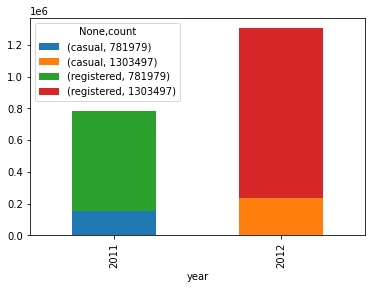

In [11]:
year.pivot_table(index = year.index, 
               columns = 'count' , values = ['casual', 'registered']).plot(kind = 'bar', stacked = True)

#### more rentals when its warmer

In [12]:
month = train.groupby(['month']).sum().reset_index()

<AxesSubplot:xlabel='month'>

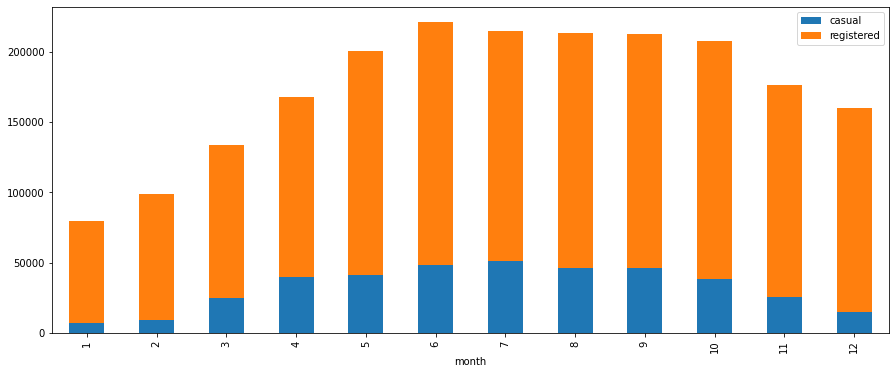

In [13]:
y = ['casual', 'registered']
month.plot.bar(x='month', y = y , stacked = True, figsize=(15,6))

<AxesSubplot:xlabel='date'>

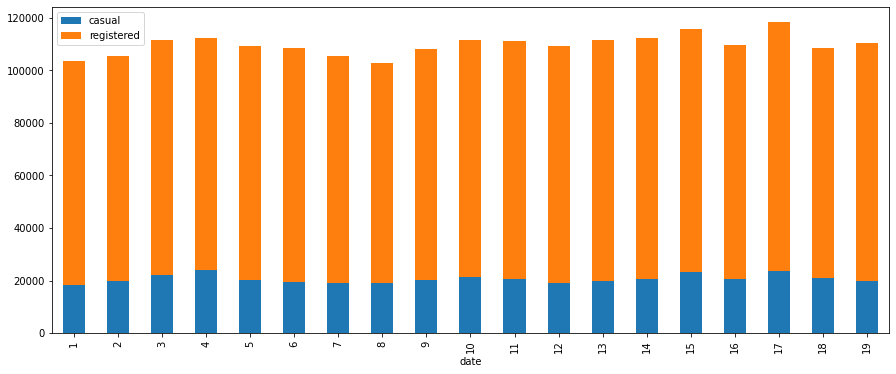

In [14]:
date = train.groupby(['date']).sum().reset_index()

date.plot.bar(x='date', y = y , stacked = True, figsize=(15,6))

#### weather

<AxesSubplot:xlabel='weather'>

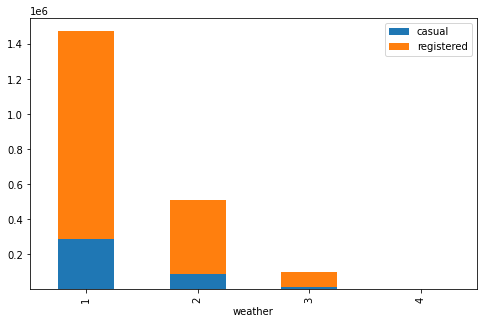

In [15]:
weather = train.groupby(['weather']).sum().reset_index()

weather.plot.bar(x='weather', y = y , stacked = True, figsize=(8,5))

#### holiday

<AxesSubplot:xlabel='holiday'>

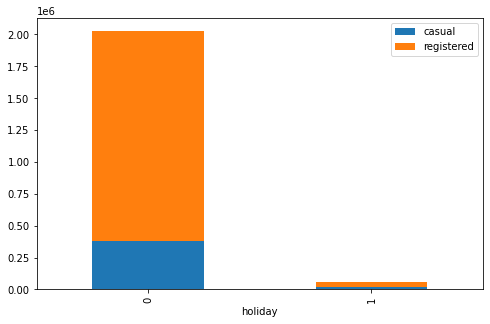

In [16]:
holiday = train.groupby(['holiday']).sum().reset_index()

holiday.plot.bar(x='holiday', y = y , stacked = True, figsize=(8,5))

# outliers

<AxesSubplot:>

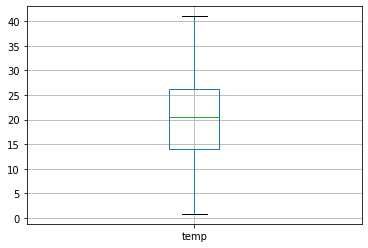

In [17]:
train.boxplot('temp')

<AxesSubplot:>

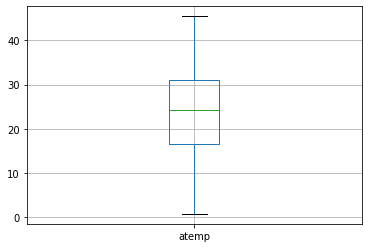

In [18]:
train.boxplot('atemp')

<AxesSubplot:>

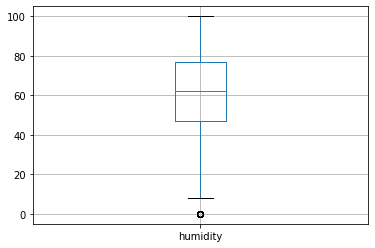

In [19]:
train.boxplot('humidity')

<AxesSubplot:>

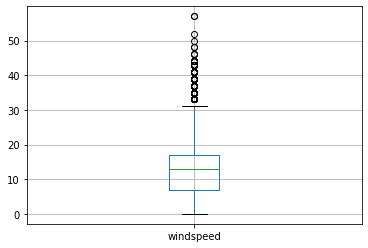

In [20]:
train.boxplot('windspeed')

<AxesSubplot:>

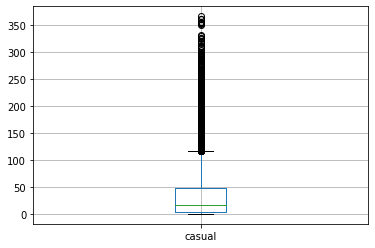

In [21]:
train.boxplot('casual')

<AxesSubplot:>

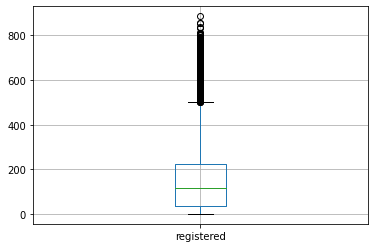

In [22]:
train.boxplot('registered')

<AxesSubplot:>

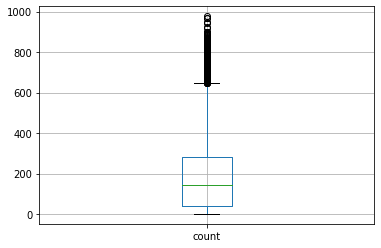

In [23]:
train.boxplot('count')

season, holiday, workingday, weather, temp, atemp, humidity, windspeed, casual, registered, count

NaN, encoding, dtype, distribution, correlation, outliers
neddco 

count, registered, casual, windspeed, humidity - has outliers, but keep for now -- might rmv if model is rlly bad 

### baseline model - without any preprocessing

In [24]:
train

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,year,month,date,hour
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0000,3,13,16,2011,1,1,0
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0000,8,32,40,2011,1,1,1
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0000,5,27,32,2011,1,1,2
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0000,3,10,13,2011,1,1,3
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0000,0,1,1,2011,1,1,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10881,2012-12-19 19:00:00,4,0,1,1,15.58,19.695,50,26.0027,7,329,336,2012,12,19,19
10882,2012-12-19 20:00:00,4,0,1,1,14.76,17.425,57,15.0013,10,231,241,2012,12,19,20
10883,2012-12-19 21:00:00,4,0,1,1,13.94,15.910,61,15.0013,4,164,168,2012,12,19,21
10884,2012-12-19 22:00:00,4,0,1,1,13.94,17.425,61,6.0032,12,117,129,2012,12,19,22


In [25]:
X = train.drop(columns = ['count', 'casual', 'registered', 'datetime', 'holiday', 'atemp'], axis = 1)
y = train['count']

Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, random_state = 0)

In [27]:
def rmsle(y, y_,convertExp=True):
    if convertExp:
        y = np.exp(y),
        y_ = np.exp(y_)
    log1 = np.nan_to_num(np.array([np.log(v + 1) for v in y]))
    log2 = np.nan_to_num(np.array([np.log(v + 1) for v in y_]))
    calc = (log1 - log2) ** 2
    return np.sqrt(np.mean(calc))

In [28]:
lr = LinearRegression()

# Train the model
ytrainlog = np.log1p(ytrain)
ytestlog = np.log1p(ytest)
lr.fit(Xtrain, ytrainlog)

# Make predictions
preds = lr.predict(X= Xtest)
print ("RMSLE Value For Linear Regression: ",rmsle(np.exp(ytestlog),np.exp(preds),False))

RMSLE Value For Linear Regression:  0.9781244193132945
